## 1. The World Bank's international debt data
<p>No es que los humanos solo tengamos deudas para administrar nuestras necesidades. Un país también puede endeudarse para administrar su economía. Por ejemplo, el gasto en infraestructura es un ingrediente costoso requerido para que los ciudadanos de un país lleven una vida cómoda. El Banco Mundial es la organización que proporciona deuda a los países.</p>

<!-- <p>En este notebook, vamos a analizar los datos de la deuda internacional recopilados por el Banco Mundial. El conjunto de datos contiene información sobre el monto de la deuda (en USD) que deben los países en desarrollo en varias categorías.</p>  -->
    

"Disbursements on external debt, long-term (DIS, current US$)",DT.DIS.DLXF.CD
"Interest payments on external debt, long-term (INT, current US$)",DT.INT.DLXF.CD
"PPG, bilateral (AMT, current US$)",DT.AMT.BLAT.CD
"PPG, bilateral (DIS, current US$)",DT.DIS.BLAT.CD
"PPG, bilateral (INT, current US$)",DT.INT.BLAT.CD
"PPG, multilateral (AMT, current US$)",DT.AMT.MLAT.CD
"PPG, multilateral (DIS, current US$)",DT.DIS.MLAT.CD
"PPG, multilateral (INT, current US$)",DT.INT.MLAT.CD
"PPG, official creditors (AMT, current US$)",DT.AMT.OFFT.CD
"PPG, official creditors (DIS, current US$)",DT.DIS.OFFT.CD
"PPG, official creditors (INT, current US$)",DT.INT.OFFT.CD
"Principal repayments on external debt, long-term (AMT, current US$)",DT.AMT.DLXF.CD
"Interest payments on external debt, private nonguaranteed (PNG) (INT, current US$)",DT.INT.DPNG.CD
"PPG, bonds (AMT, current US$)",DT.AMT.PBND.CD
"PPG, bonds (INT, current US$)",DT.INT.PBND.CD
"PPG, commercial banks (AMT, current US$)",DT.AMT.PCBK.CD
"PPG, commercial banks (DIS, current US$)",DT.DIS.PCBK.CD
"PPG, commercial banks (INT, current US$)",DT.INT.PCBK.CD
"PPG, other private creditors (AMT, current US$)",DT.AMT.PROP.CD
"PPG, other private creditors (DIS, current US$)",DT.DIS.PROP.CD
"PPG, other private creditors (INT, current US$)",DT.INT.PROP.CD
"PPG, private creditors (AMT, current US$)",DT.AMT.PRVT.CD
"PPG, private creditors (DIS, current US$)",DT.DIS.PRVT.CD
"PPG, private creditors (INT, current US$)",DT.INT.PRVT.CD
"Principal repayments on external debt, private nonguaranteed (PNG) (AMT, current US$)",DT.AMT.DPNG.CD

<p>Vamos a encontrar las respuestas a preguntas como:

<p>¿Cuál es el monto total de la deuda que deben los países enumerados en el conjunto de datos?
<p>¿Qué país posee la cantidad máxima de deuda y cómo se ve esa cantidad?
<p>¿Cuál es el monto promedio de la deuda de los países a través de diferentes indicadores de deuda?
    
Además tenemos otro dataset en el que encontramos información histórica de algunos índices de desarrollo, entre los que se encuentran algunos de deuda como son:

Series Name,Series Code
"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN

"Central government debt, total (current LCU)",GC.DOD.TOTL.CN

"Central government debt, total (% of GDP)",GC.DOD.TOTL.GD.ZS

#### 1. Inicializar y cargar el contexto spark

Cargamos el contexto Spark

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz #d
!pip install -q findspark 

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" #funciones dels sistema de python para cambiar variables de entorno y que funcione
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark #tenemos que generar un contexto spark para trabajar
findspark.init()
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate() #generamos una sesi



Generamos el contexto spark con sql



In [3]:
# Creamos el contexto spark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

    # Creamos la sesión de spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

    # Importamos las sesiones
from pyspark.sql.functions import col, avg, desc, sum

Una vez hemos iniciado spark podemos cargar los datos con la función textFile(), ver que estructura siguen los datos y el número de registros de manera que posteriormente podamos realizar el parseado.

- Fichero Desarrollo

In [7]:
# Cargamos los datos
raw_desarrollo = spark.read.format("csv") \
    .option("sep", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("indicadores_desarrollo.csv")

# Vemos las primeras 10 filas
raw_desarrollo.show(10)

+------------+------------+-------------+---------------+------------------+--------------+
|country_name|country_code|         anho| GC.DOD.TOTL.CN| GC.DOD.TOTL.GD.ZS|SP.DYN.CBRT.IN|
+------------+------------+-------------+---------------+------------------+--------------+
|     Albania|         ALB|2014 [YR2014]|   1.0230408E12|  73.3202469198429|        12.259|
|     Albania|         ALB|2015 [YR2015]|  1.14550094E12|  79.8644448747259|        12.197|
|     Albania|         ALB|2016 [YR2016]|  1.18881449E12|  80.7355748396923|         12.08|
|   Australia|         AUS|2014 [YR2014]|        6.747E8| 0.042207528166503|          13.2|
|   Australia|         AUS|2015 [YR2015]|      7.62718E8|0.0469480198522591|          12.9|
|   Australia|         AUS|2016 [YR2016]|      9.07555E8| 0.054648482520169|          12.9|
|Bahamas, The|         BHS|2014 [YR2014]|      5.15842E9|  47.2672793747079|         14.34|
|Bahamas, The|         BHS|2015 [YR2015]|      5.65515E9|  48.1195170307089|    

In [8]:
# Aplicamos un count
raw_desarrollo.count()

134

In [10]:
# Observamos los datos con printSchema()
raw_desarrollo.printSchema()

root
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- anho: string (nullable = true)
 |-- GC.DOD.TOTL.CN: double (nullable = true)
 |-- GC.DOD.TOTL.GD.ZS: double (nullable = true)
 |-- SP.DYN.CBRT.IN: double (nullable = true)



In [11]:
# Para renombrar las columnas utilizaremos la función withColumnRenamned()
desarrollo = raw_desarrollo.withColumnRenamed("anho", "year") \
    .withColumnRenamed("GC.DOD.TOTL.CN", "gob_debt") \
    .withColumnRenamed("GC.DOD.TOTL.GD.ZS", "gob_debt_tot") \
    .withColumnRenamed("SP.DYN.CBRT.IN", "birth_rate")

    # Comprobamos si ha cambiado...
desarrollo.printSchema()

root
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- year: string (nullable = true)
 |-- gob_debt: double (nullable = true)
 |-- gob_debt_tot: double (nullable = true)
 |-- birth_rate: double (nullable = true)



- Fichero Deuda

In [12]:
# Cargamos los datos
raw_deuda = spark.read.format("csv") \
    .option("sep", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("indicadores_deuda.csv")

# Observamos las primeras 10 filas
raw_deuda.show(10)

+------------+------------+--------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|country_name|country_code|DT.AMT.BLAT.CD|  DT.AMT.DLXF.CD|DT.AMT.DPNG.CD|DT.AMT.MLAT.CD|DT.AMT.OFFT.CD|DT.AMT.PBND.CD|DT.AMT.PCBK.CD|DT.AMT.PROP.CD|DT.AMT.PRVT.CD|DT.DIS.BLAT.CD|  DT.DIS.DLXF.CD|DT.DIS.MLAT.CD|DT.DIS.OFFT.CD|DT.DIS.PCBK.CD|DT.DIS.PROP.CD|DT.DIS.PRVT.CD|DT.INT.BLAT.CD|DT.INT.DLXF.CD|DT.INT.DPNG.CD|DT.INT.MLAT.CD|DT.INT.OFFT.CD|DT.INT.PBND.CD|DT.INT.PCBK.CD|DT.INT.PROP.CD|DT.INT.PRVT.CD|
+------------+------------+--------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------

In [13]:
# Funcion count
raw_deuda.count()

124

In [14]:
# Observamos los datos con printSchema()
raw_deuda.printSchema()

root
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- DT.AMT.BLAT.CD: double (nullable = true)
 |-- DT.AMT.DLXF.CD: double (nullable = true)
 |-- DT.AMT.DPNG.CD: double (nullable = true)
 |-- DT.AMT.MLAT.CD: double (nullable = true)
 |-- DT.AMT.OFFT.CD: double (nullable = true)
 |-- DT.AMT.PBND.CD: double (nullable = true)
 |-- DT.AMT.PCBK.CD: double (nullable = true)
 |-- DT.AMT.PROP.CD: double (nullable = true)
 |-- DT.AMT.PRVT.CD: double (nullable = true)
 |-- DT.DIS.BLAT.CD: double (nullable = true)
 |-- DT.DIS.DLXF.CD: double (nullable = true)
 |-- DT.DIS.MLAT.CD: double (nullable = true)
 |-- DT.DIS.OFFT.CD: double (nullable = true)
 |-- DT.DIS.PCBK.CD: double (nullable = true)
 |-- DT.DIS.PROP.CD: double (nullable = true)
 |-- DT.DIS.PRVT.CD: double (nullable = true)
 |-- DT.INT.BLAT.CD: double (nullable = true)
 |-- DT.INT.DLXF.CD: double (nullable = true)
 |-- DT.INT.DPNG.CD: double (nullable = true)
 |-- DT.INT.MLAT.CD: double (null

In [15]:
deuda = raw_deuda

##### 2. Número de países distintos en cada dataset. Coinciden?

Para conocer el numero de países distintos en cada base de datos utilizamos el comando select para seleccionar la columna country_name, que contiene los nombres. Una vez seleccionada, utilizamos la función distinct que reconoce aquellos que son distintos y el count para sumar los que te devuelva la funcion distinct

In [17]:
# Para fichero de desarrollo
desarrollo.select("country_name").distinct().count()


51

In [18]:
# Para el fichero de deuda
deuda.select("country_name").distinct().count()


124

##### 3. Total de deuda contraida por cada pais: total amount of debt (in USD) DT.AMT.MLAT.CD

Debemos utilizar el df de `deuda` donde se encuentra la columna "DT.AMT.MLAT.CD", que nos devuelve la deuda total contraída por cada país. 

Para ello, primero cambiamos el nombre de la columna para hacerla másmanejable y luego volvemos a utilizar el `select` en dicha columna

In [21]:
# Renombramos la columna
deuda = deuda.withColumnRenamed("DT.AMT.MLAT.CD", "total_debt")

# Seleccionamos total_debt junto con country_name
deuda.select("country_name", "total_debt").show(124)

+--------------------+--------------+
|        country_name|    total_debt|
+--------------------+--------------+
|         Afghanistan|   3.9107845E7|
|             Albania| 1.821976167E8|
|             Algeria|           0.0|
|              Angola| 1.246886919E8|
|             Armenia|  9.43312071E7|
|          Azerbaijan| 5.136236565E8|
|          Bangladesh|1.0395646827E9|
|             Belarus|  5.95438826E8|
|              Belize|  2.96833265E7|
|               Benin|  9.16316395E7|
|              Bhutan|  1.73904205E7|
|             Bolivia| 3.577212115E8|
|Bosnia and Herzeg...| 2.901709465E8|
|            Botswana| 1.256523445E8|
|              Brazil|2.5143187416E9|
|            Bulgaria| 2.289930198E8|
|        Burkina Faso|  1.19510893E8|
|             Burundi|  1.61151118E7|
|          Cabo Verde|  3.99701249E7|
|            Cambodia|  7.23070018E7|
|            Cameroon| 1.520959681E8|
|Central African R...|     2241813.8|
|                Chad|  9.57387095E7|
|           

##### 4. Media de los indicadores de deuda (tabla uno): DT.AMT.BLAT.CD, DT.DIS.BLAT.CD, DT.INT.BLAT.CD

Mismo procedimiento al cambiar los nombres como en el ejercicio anterior.

Posteriormente aplicamos la funcion avg para sacar la media

In [23]:
# Renombramos las 3 variables
deuda = deuda.withColumnRenamed("DT.AMT.BLAT.CD", "PPG_bi_AMT") \
    .withColumnRenamed("DT.DIS.BLAT.CD", "PPG_bi_DIS") \
    .withColumnRenamed("DT.INT.BLAT.CD", "PPG_bi_INT")

# Utilizamos avg en las columnas seleccionadas
deuda.select(avg("PPG_bi_AMT"), avg("PPG_bi_DIS"), avg("PPG_bi_INT")).show()

+-------------------+------------------+-------------------+
|    avg(PPG_bi_AMT)|   avg(PPG_bi_DIS)|    avg(PPG_bi_INT)|
+-------------------+------------------+-------------------+
|7.126196346598358E8|1.22313929039823E9|1.640932856090164E8|
+-------------------+------------------+-------------------+



##### 5. Los 20 paises con DT.AMT.DLXF.CD más alto

Volvemos a cambiar los nombres y seleccionamos los 20 primeros en orden de mayor a menor (desc)

In [24]:
# Renombramos la columna
deuda = deuda.withColumnRenamed("DT.AMT.DLXF.CD", "int_paymt_ex_debt")

# Ordenamos en orden descendente
deuda.select("country_name", "int_paymt_ex_debt").sort(desc("int_paymt_ex_debt")).show(20)

+--------------------+-----------------+
|        country_name|int_paymt_ex_debt|
+--------------------+-----------------+
|               China| 9.62186208357E10|
|              Brazil| 9.00418403041E10|
|  Russian Federation| 6.65897618335E10|
|              Turkey| 5.15550310058E10|
|          South Asia| 4.87562958982E10|
|               India| 3.19235070008E10|
|           Indonesia| 3.09161126538E10|
|          Kazakhstan| 2.74820936864E10|
|              Mexico|  2.5218503927E10|
|Least developed c...| 2.51970292994E10|
|            IDA only|  2.0483289208E10|
|             Romania| 1.40137833504E10|
|            Colombia| 1.19856744387E10|
|              Angola| 1.10670456281E10|
|            Cameroon| 1.04048149602E10|
|       Venezuela, RB|   9.8786592072E9|
|    Egypt, Arab Rep.|   9.6921141769E9|
|             Lebanon|   9.5069196696E9|
|        South Africa|   9.4742575519E9|
|             Vietnam|   8.8735059092E9|
+--------------------+-----------------+
only showing top

##### 6. Pais con los datos informados todos los años.

Utilizamos para esto el dataset de `desarrollo` Primero agrupamos por año para ver cuantos paises hay cada año

In [26]:
# Agrupamos por año
desarrollo.groupBy("year").count().show()

+-------------+-----+
|         year|count|
+-------------+-----+
|2016 [YR2016]|   39|
|2014 [YR2014]|   50|
|2017 [YR2017]|    1|
|2015 [YR2015]|   44|
+-------------+-----+



In [28]:
# Agrupamos por paises y hacemos un count para saber el numero de veces que aparecen. Dentro del 
# groupby filtramos por aquellos que aparezcan cuatro veces (hay 4 años)
desarrollo.groupBy("country_name").count() \
    .filter("count == 4") \
    .show()

+------------+-----+
|country_name|count|
+------------+-----+
|      Malawi|    4|
+------------+-----+



##### 7. Media anual de los distintos indicadores de desarrollo

Utilizamos la funcion avg para las medias de los indicadores

In [30]:
# Agrupamos para saber el dato de cada año
desarrollo.groupBy("year").agg(avg("gob_debt"), avg("gob_debt_tot"), avg("birth_rate")).show()

+-------------+--------------------+------------------+------------------+
|         year|       avg(gob_debt)| avg(gob_debt_tot)|   avg(birth_rate)|
+-------------+--------------------+------------------+------------------+
|2016 [YR2016]|1.588138215480659...|58.796949624008356| 16.14433333333333|
|2014 [YR2014]|1.034427587329532...|56.843914344384395|          17.58262|
|2017 [YR2017]| 2.23985861996269E12|   48.659564238322|            34.593|
|2015 [YR2015]|1.318244039159024...| 58.36559834488036|16.798477272727276|
+-------------+--------------------+------------------+------------------+



##### 8. Podrías decirme el total de deuda acumulada DT.AMT.MLAT.CD por los 10 países con un valor en media menor de SP.DYN.CBRT.IN

Como es informacion contenida en dos tablas diferentes debemos utilizar un join y juntar los dos datasets

In [31]:
desDeu = desarrollo.join(other=deuda, on=["country_code", "country_name"], how="inner")
desDeu.printSchema()

root
 |-- country_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- year: string (nullable = true)
 |-- gob_debt: double (nullable = true)
 |-- gob_debt_tot: double (nullable = true)
 |-- birth_rate: double (nullable = true)
 |-- PPG_bi_AMT: double (nullable = true)
 |-- int_paymt_ex_debt: double (nullable = true)
 |-- DT.AMT.DPNG.CD: double (nullable = true)
 |-- total_debt: double (nullable = true)
 |-- DT.AMT.OFFT.CD: double (nullable = true)
 |-- DT.AMT.PBND.CD: double (nullable = true)
 |-- DT.AMT.PCBK.CD: double (nullable = true)
 |-- DT.AMT.PROP.CD: double (nullable = true)
 |-- DT.AMT.PRVT.CD: double (nullable = true)
 |-- PPG_bi_DIS: double (nullable = true)
 |-- DT.DIS.DLXF.CD: double (nullable = true)
 |-- DT.DIS.MLAT.CD: double (nullable = true)
 |-- DT.DIS.OFFT.CD: double (nullable = true)
 |-- DT.DIS.PCBK.CD: double (nullable = true)
 |-- DT.DIS.PROP.CD: double (nullable = true)
 |-- DT.DIS.PRVT.CD: double (nullable = true)
 |-- PPG_bi_INT: d

In [39]:
debt_birth = desDeu.select("country_name", "total_debt", "birth_rate")
debt_birth.show()

+------------+--------------+----------+
|country_name|    total_debt|birth_rate|
+------------+--------------+----------+
|     Albania| 1.821976167E8|     12.08|
|     Albania| 1.821976167E8|    12.197|
|     Albania| 1.821976167E8|    12.259|
|     Belarus|  5.95438826E8|      12.4|
|     Belarus|  5.95438826E8|      12.5|
|     Belarus|  5.95438826E8|      12.5|
|      Belize|  2.96833265E7|    22.067|
|      Bhutan|  1.73904205E7|    17.625|
|      Bhutan|  1.73904205E7|    17.783|
|      Bhutan|  1.73904205E7|    17.965|
|    Botswana| 1.256523445E8|    25.943|
|    Botswana| 1.256523445E8|     26.44|
|    Botswana| 1.256523445E8|     26.87|
|      Brazil|2.5143187416E9|    14.307|
|      Brazil|2.5143187416E9|    14.472|
|      Brazil|2.5143187416E9|    14.624|
|    Colombia|1.1009075536E9|    15.308|
|    Colombia|1.1009075536E9|    15.515|
|    Colombia|1.1009075536E9|    15.725|
| El Salvador| 2.989396871E8|    18.587|
+------------+--------------+----------+
only showing top

In [40]:
acu_debt = debt_birth.groupBy("country_name", "total_debt").agg(avg("birth_rate"))
acu_debt.show()

+--------------------+--------------+------------------+
|        country_name|    total_debt|   avg(birth_rate)|
+--------------------+--------------+------------------+
|     Kyrgyz Republic|  7.52780372E7| 27.03333333333333|
|         El Salvador| 2.989396871E8|18.733999999999998|
|    Papua New Guinea|   7.8345326E7|           28.1685|
|              Bhutan|  1.73904205E7|            17.791|
|             Albania| 1.821976167E8|12.178666666666667|
|             Ukraine|1.0724728303E9|              10.6|
|              Jordan| 2.704987155E8|            24.305|
|              Turkey| 2.932698678E9|16.717333333333332|
|         Philippines| 7.390564273E8|            22.935|
|           St. Lucia|  1.50192163E7|            12.502|
|           Sri Lanka| 4.497719611E8|            16.729|
|             Belarus|  5.95438826E8|12.466666666666667|
|St. Vincent and t...|  2.16156007E7|            15.011|
|     Solomon Islands|     3952828.9|33.525666666666666|
|             Georgia| 1.440624

In [41]:
acu_debt = acu_debt.sort("avg(birth_rate)").limit(10)
acu_debt.show()

+--------------------+--------------+------------------+
|        country_name|    total_debt|   avg(birth_rate)|
+--------------------+--------------+------------------+
|             Ukraine|1.0724728303E9|              10.6|
|             Moldova| 1.358428655E8|10.604333333333335|
|            Thailand|  3.90715715E7|           10.9175|
|             Albania| 1.821976167E8|12.178666666666667|
|             Belarus|  5.95438826E8|12.466666666666667|
|           St. Lucia|  1.50192163E7|            12.502|
|  Russian Federation|    1.416695E8|13.166666666666666|
|             Georgia| 1.440624015E8|            14.056|
|              Brazil|2.5143187416E9|14.467666666666666|
|St. Vincent and t...|  2.16156007E7|            15.011|
+--------------------+--------------+------------------+



In [43]:
acu_debt.select(sum("total_debt")).show()

+-------------------+
|    sum(total_debt)|
+-------------------+
|4.861709170099999E9|
+-------------------+



##### 9. ¿Hay alguna relación entre los nacimientos y el indicador DT.AMT.DLXF.CD? ¿Cómo podrías demostrarlo?

In [44]:

debt_birth = desDeu.select("country_name", "int_paymt_ex_debt", "birth_rate") \
    .groupBy("country_name", "int_paymt_ex_debt").agg(avg("birth_rate"))


debt_birth.show()

+------------------+-----------------+------------------+
|      country_name|int_paymt_ex_debt|   avg(birth_rate)|
+------------------+-----------------+------------------+
|         Sri Lanka|   5.7614892559E9|            16.729|
|           Ukraine|   8.1489956256E9|              10.6|
|Russian Federation| 6.65897618335E10|13.166666666666666|
|        Kazakhstan| 2.74820936864E10| 22.77666666666667|
|   Solomon Islands|     3.07497039E7|33.525666666666666|
|            Brazil| 9.00418403041E10|14.467666666666666|
|   Kyrgyz Republic|    8.164190451E8| 27.03333333333333|
|         Guatemala|   2.9119819878E9|25.628666666666664|
|         St. Lucia|     2.03326738E7|            12.502|
|            Bhutan|    2.132585369E8|            17.791|
|             Tonga|     1.03699106E7|25.362333333333336|
|            Zambia|   1.2176434719E9|           38.2975|
|         Indonesia| 3.09161126538E10|19.163999999999998|
|           Jamaica|    5.595974314E8| 16.63566666666667|
|            T

Vamos a pasar nuestro dataframe a version pandas para poder trabajar con ello mejor y dibujar una grafica entre ambas variables

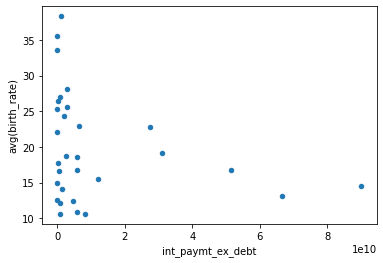

In [45]:
# Importamos pandas
import pandas as pd
    
# Formato pandas
pd_debt_birth = debt_birth.toPandas()

# Dibujamos
pd_debt_birth.plot.scatter(x="int_paymt_ex_debt", y="avg(birth_rate)");

Según la grafica no parece haber ninguna relacion lineal entre las dos variables estudiadas